<a href="https://colab.research.google.com/github/jblcky/retail-pharmacy-inventory-optimization/blob/main/notebooks/05_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Paths
forecast_dir = '/content/drive/My Drive/sku_forecasts'
inventory_plan_path = '/content/drive/My Drive/inventory_optimization_plan.csv'
output_sim_path = '/content/drive/My Drive/inventory_simulation_results.csv'

# Load inventory plan
inv_df = pd.read_csv(inventory_plan_path)

# Simulate for each SKU
sim_results = []

for _, row in inv_df.iterrows():
    sku = row['sku_id']
    EOQ = row['EOQ']
    ROP = row['ROP']

    forecast_path = f"{forecast_dir}/{sku}_forecast.csv"
    if not os.path.exists(forecast_path):
        print(f"⚠️ Missing forecast for {sku}, skipping.")
        continue

    forecast_df = pd.read_csv(forecast_path, parse_dates=['ds'])
    forecast_df = forecast_df[['ds', 'yhat']].copy()
    forecast_df['yhat'] = forecast_df['yhat'].clip(lower=0).round().astype(int)
    forecast_df['week'] = forecast_df['ds'].dt.isocalendar().week

    # Initialize simulation
    inventory = EOQ  # start with 1 EOQ batch
    reorder_qty = EOQ
    reorder_lead_time = 1  # weeks
    pending_orders = []
    reorder_log = []

    for i, rowf in forecast_df.iterrows():
        week = rowf['ds']
        demand = rowf['yhat']

        # Receive any deliveries
        pending_orders = [(wk, qty) for wk, qty in pending_orders if wk > week]
        arrived = sum(qty for wk, qty in pending_orders if wk == week)
        inventory += arrived

        # Fulfill demand
        sales = min(demand, inventory)
        stockout = max(0, demand - inventory)
        inventory -= sales

        # Check ROP and reorder if needed
        if inventory <= ROP:
            pending_orders.append((week + pd.Timedelta(weeks=reorder_lead_time), reorder_qty))
            reorder_log.append((week, reorder_qty))

        # Log result
        sim_results.append({
            'sku_id': sku,
            'week': week,
            'forecast_demand': demand,
            'sales': sales,
            'stockout': stockout,
            'inventory_level': inventory
        })

print("✅ Simulation complete.")

# Save simulation results
sim_df = pd.DataFrame(sim_results)
sim_df.to_csv(output_sim_path, index=False)
print(f"📁 Saved to {output_sim_path}")


Mounted at /content/drive
✅ Simulation complete.
📁 Saved to /content/drive/My Drive/inventory_simulation_results.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


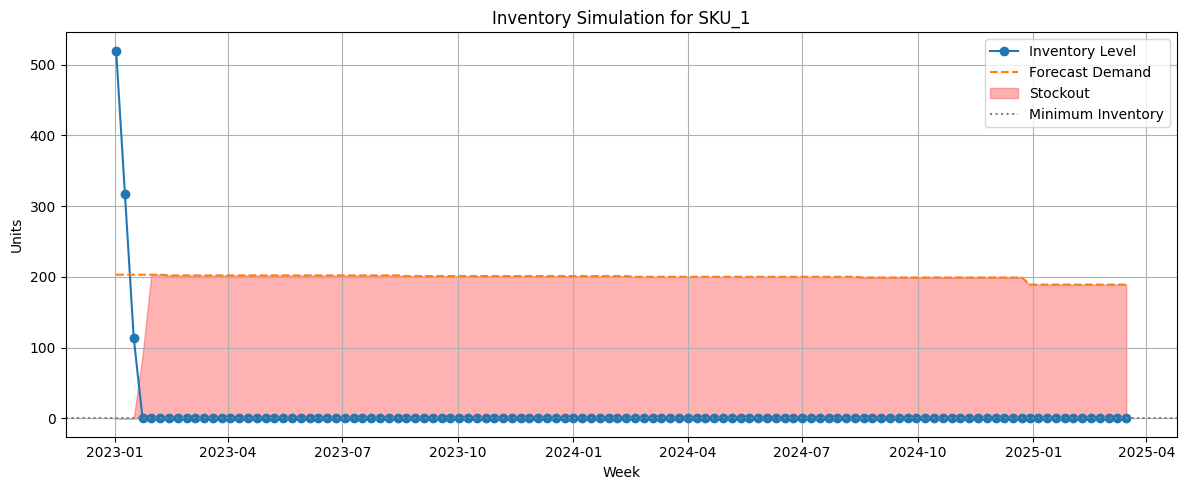

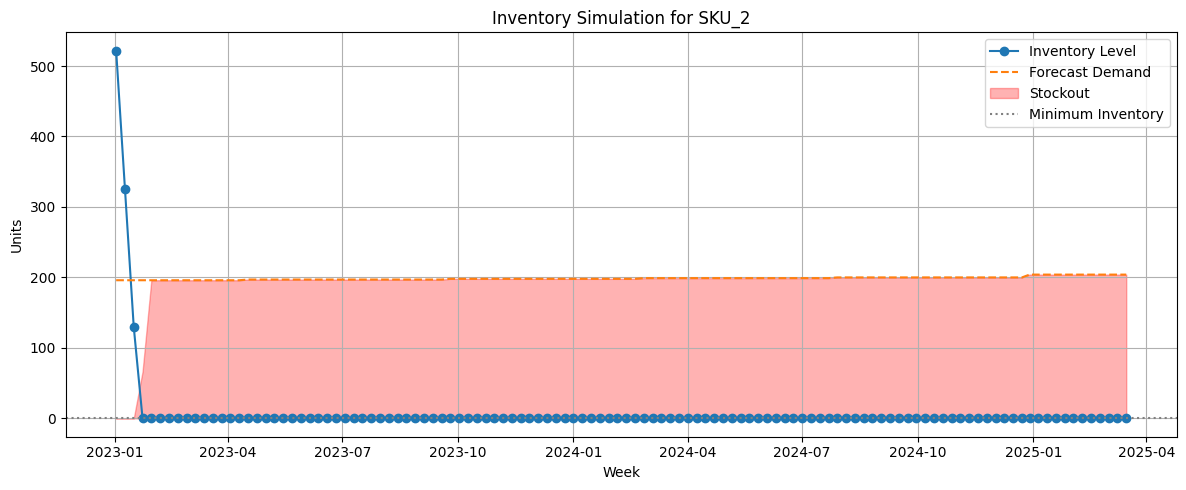

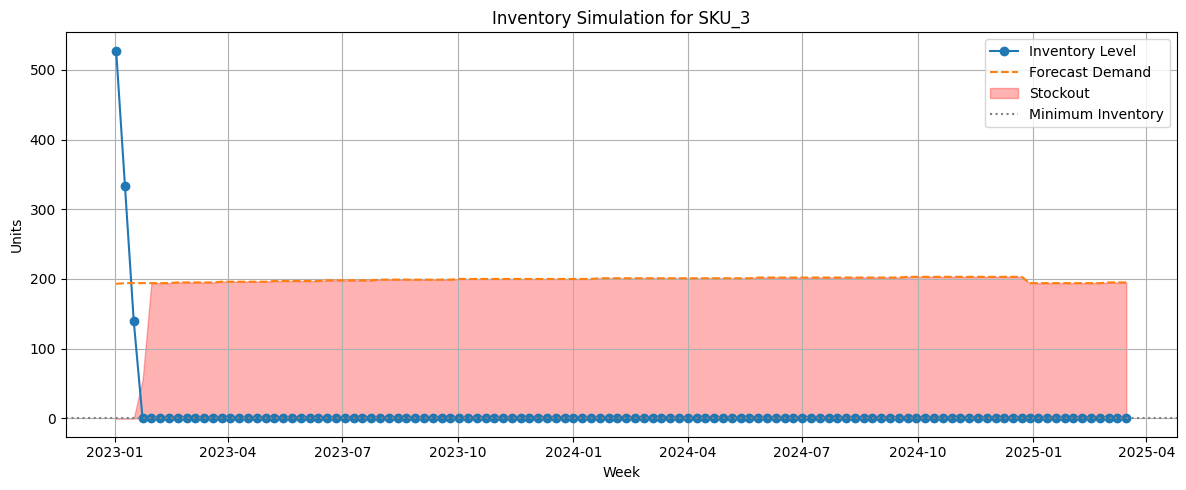

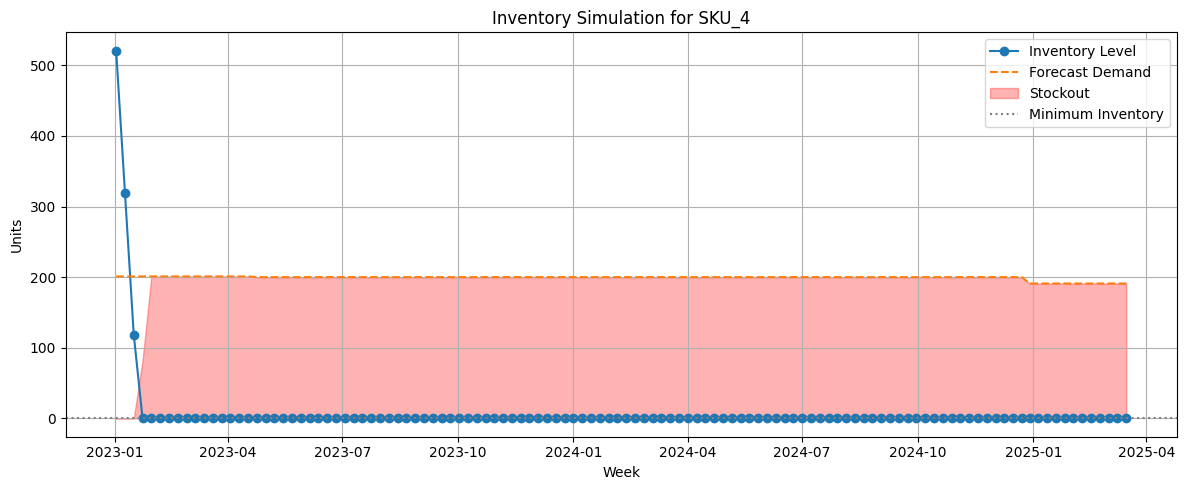

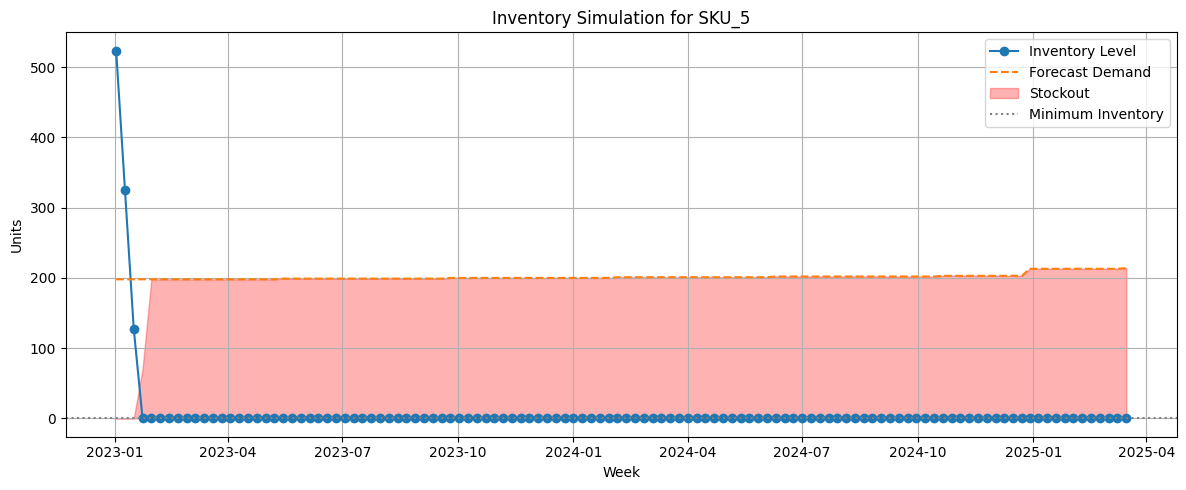

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load simulation results
sim_path = '/content/drive/My Drive/inventory_simulation_results.csv'
sim_df = pd.read_csv(sim_path, parse_dates=['week'])

# Pick SKUs to visualize (change to all if needed)
sku_list = sim_df['sku_id'].unique()[:5]  # first 5 for demo

for sku in sku_list:
    sku_df = sim_df[sim_df['sku_id'] == sku].sort_values('week')

    plt.figure(figsize=(12, 5))
    plt.plot(sku_df['week'], sku_df['inventory_level'], label='Inventory Level', marker='o')
    plt.plot(sku_df['week'], sku_df['forecast_demand'], label='Forecast Demand', linestyle='--')
    plt.fill_between(sku_df['week'], 0, sku_df['stockout'], color='red', alpha=0.3, label='Stockout')

    plt.axhline(y=sku_df['inventory_level'].min(), color='gray', linestyle=':', label='Minimum Inventory')
    plt.title(f'Inventory Simulation for {sku}')
    plt.xlabel('Week')
    plt.ylabel('Units')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
